Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [2]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:34<00:00, 291kB/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 288kB/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:02<00:00, 710kB/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

In [4]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


In [5]:
class Encoder(nn.Module): # nn.Module is the base class for all neural network modules in PyTorch
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__() # super() allows calling methods of the base class.
        self.D_latent = D_latent 
        
        # Define any networks (which extend 'nn.Module') here:
        # Anything that has parameters should be defined here!
        
        # e.g., a linear layer could be defined as 
        # self.fc = nn.Linear(784, D_latent)
        #
        # Later on in the `.forward` method, you then can call this.
        #
        # Some ``useful'' layers include:
        #
        # nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...

        # YOUR CODE HERE
        self.network = nn.Sequential( # (1, 28, 28) initially
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=2, padding=1), # reduce dim to (6,14,14)
            nn.BatchNorm2d(6), # to avoid vanishing/exploding gradients
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=4, stride=2, padding=1), # reduce dim to (12,7,7)
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=2, padding=1), # reduce dim to (16, 4, 4)
            nn.BatchNorm2d(16),
            nn.Flatten() # Flatten the 2D feature maps to 1D tensor of shape as the linear layer requires 1D input
        ) 
        # convolutional channels can't be too small, as it limits the model's capacity to extract rich features from input
        
        # After the convolutional layers, we have a 1D tensor of size 256 (16*4*4)
        # Then, we use linear layers here to define the parameters (weights and biases) of miu and sigma
        self.mu = nn.Linear(in_features=256, out_features=D_latent) 
        self.logvar = nn.Linear(in_features=256, out_features=D_latent) # Ensure variances are positive

    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # YOUR CODE HERE
        features = self.network(X) # Pass the input batch X through CNN layers, output is a 256-dim vector for the image's feature representation
        mu = self.mu(features) # compute the mean vector of the latent 
        sigma = torch.exp(0.5 * self.logvar(features)) # compute the standard deviation vector of the latent
        
        # Ensure output shapes match
        assert mu.shape == (X.shape[0], self.D_latent)
        assert mu.shape == sigma.shape
        
        return dist.Normal(mu, sigma) # return a pytorch distribution for q(z|x)
            
        # The following template might be helpful:
#         mu = ?
#         sigma = ?
#         assert mu.shape == (X.shape[0], self.D_latent)
#         assert mu.shape == sigma.shape
#         return dist.Normal(mu, sigma)

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define your networks here
        
        # YOUR CODE HERE
        self.latent_to_features = nn.Sequential(
            nn.Linear(in_features=D_latent, out_features=256),
            nn.ReLU()
        )
        
        self.feature_to_image = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=12, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """

        # Make sure that the returned value has the right shape! e.g.:
        # return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))
        
        # YOUR CODE HERE
        features = self.latent_to_features(Z)
        features = features.view(-1, 16, 4, 4) # reshape the 1D tensor to 2D tensor for the convolutional layers
        X_hat = torch.sigmoid(self.feature_to_image(features)) # X_hat is between 0 and 1, representing the probabilities of the binary pixel being 1 or 0
        
        return dist.Bernoulli(X_hat) # X_hat is the reconstructed image (i.e. probabilities for binary pixel)


In [6]:
# Test: Check the number of parameters used when D_latent = 10
# D_latent = 10
# encoder = Encoder(D_latent=D_latent)
# decoder = Decoder(D_latent=D_latent)
#def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate parameters for encoder and decoder
#encoder_params = count_parameters(encoder)
#decoder_params = count_parameters(decoder)

#print(f"Number of parameters in Encoder: {encoder_params}") # parameters depend on output channels, kernel size and batch norm. 
#print(f"Number of parameters in Decoder: {decoder_params}")

Number of parameters in Encoder: 8218
Number of parameters in Decoder: 5265


' Calculation of Decoder parameters:\n# 1. Latent-to-Features Linear Layer:\n#    Input Features: 10, Output Features: 256\n#    Weights: 10 * 256 = 2560\n#    Biases: 256\n#    Total: 2560 + 256 = 2816\n#\n# 2. First Transposed Conv2d Layer:\n#    Input Channels: 16, Output Channels: 12, Kernel Size: 3x3\n#    Weights: 16 * 12 * 3 * 3 = 1728\n#    Biases: 12\n#    Total: 1728 + 12 = 1740\n#\n# 3. Second Transposed Conv2d Layer:\n#    Input Channels: 12, Output Channels: 6, Kernel Size: 3x3\n#    Weights: 12 * 6 * 3 * 3 = 648\n#    Biases: 6\n#    Total: 648 + 6 = 654\n#\n# 4. Third Transposed Conv2d Layer:\n#    Input Channels: 6, Output Channels: 1, Kernel Size: 3x3\n#    Weights: 6 * 1 * 3 * 3 = 54\n#    Biases: 1\n#    Total: 54 + 1 = 55\n#\n# Total Decoder Parameters:\n# 2816 + 1740 + 654 + 55 = 5265\n'

# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [7]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28)
    
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """

    # YOUR CODE HERE

    # Obtain the latent distribution q(z | x)
    q_z_x = enc(X) # encoder returns a normal distribution
    z = q_z_x.rsample() # reparameterization trick to sample z
    
    # loglikelihood of reconstructed data p(x | z)
    p_x_z = dec(z) # decoder returns a bernoulli distribution
    log_p_x_z = p_x_z.log_prob(X).sum(dim=(1, 2, 3))
    
    # KL divergence between q(z | x) and p(z)
    log_q_z_x = q_z_x.log_prob(z).sum(dim=1) # sum over latent dim
    log_p_z = dist.Normal(0, 1).log_prob(z).sum(dim=1)
    kl_div = log_q_z_x - log_p_z
    
    elbo = log_p_x_z - kl_div # per-data ELBO
    
    return elbo


# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [22]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [23]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [10]:
# ignore this cell (placeholder)


In [24]:
N_epochs = 40 # Note that you may want to run more epochs!
run_training(N_epochs, enc, dec) # around 10000 training loss (sum) after 40 epochs

Epoch 0, train loss = 21387.9444
Epoch 1, train loss = 12806.1319
Epoch 2, train loss = 11960.9245
Epoch 3, train loss = 11567.9765
Epoch 4, train loss = 11318.8139
Epoch 5, train loss = 11151.7779
Epoch 6, train loss = 11005.0983
Epoch 7, train loss = 10897.7631
Epoch 8, train loss = 10802.1810
Epoch 9, train loss = 10719.4640
Epoch 10, train loss = 10647.3826
Epoch 11, train loss = 10580.7603
Epoch 12, train loss = 10512.4301
Epoch 13, train loss = 10471.1546
Epoch 14, train loss = 10420.2165
Epoch 15, train loss = 10385.0842
Epoch 16, train loss = 10342.7922
Epoch 17, train loss = 10308.1374
Epoch 18, train loss = 10271.3614
Epoch 19, train loss = 10244.0712
Epoch 20, train loss = 10216.8727
Epoch 21, train loss = 10200.1181
Epoch 22, train loss = 10172.6464
Epoch 23, train loss = 10152.0767
Epoch 24, train loss = 10128.8965
Epoch 25, train loss = 10118.5618
Epoch 26, train loss = 10103.0860
Epoch 27, train loss = 10085.4783
Epoch 28, train loss = 10069.2043
Epoch 29, train loss = 1

## Do reconstructions look like the input?

In [25]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))

print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

Reconstruction accuracy: 0.94


## Do randomly generated samples look coherent?

In [19]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

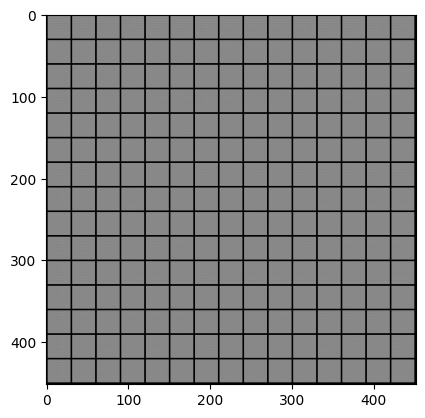

<Figure size 1000x1000 with 0 Axes>

In [21]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
plt.show()
out = plot_2d_latent(enc, dec)

In [15]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [16]:
# grading


In [17]:
# grading


In [18]:
# grading


In [19]:
# grading


In [20]:
# grading


In [21]:
# grading


In [22]:
# grading
